In [1]:
# Import des libraries
import sys
sys.path.insert(0, '../src/')

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import graphviz
import shap
import skater
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel


import xgboost as xgb 

# Importing libraries - sklearn
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle       # for saving/loading train-test sets

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import auto_co2 as co2

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

2024-01-26 11:15:19.318246: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-26 11:15:19.335691: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **0. Introduction**


In [2]:
%%time
# Import des données: le dataset entier a pour chemin d'accès: data/processed/co2_classification_xx...
file_path = "../data/sample/co2_regression_sample.csv"
df = pd.read_csv(file_path)

target = df['Co2EmissionsWltp']
data = df.drop(columns='Co2EmissionsWltp')
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=.3, random_state=100)

scaler = preprocessing.StandardScaler()
X_train[X_train.columns] = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)
X_test[X_test.columns] = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

CPU times: user 7.74 ms, sys: 9.9 ms, total: 17.6 ms
Wall time: 17.1 ms


In [3]:
"""
co2.styles.display_info(df)
co2.styles.displayer(data)
co2.styles.displayer(pd.DataFrame(target))

co2.viz.plot_continuous_distribution(target)
"""

'\nco2.styles.display_info(df)\nco2.styles.displayer(data)\nco2.styles.displayer(pd.DataFrame(target))\n\nco2.viz.plot_continuous_distribution(target)\n'

# **1. Régression Linéaire**

Save: True
Saved PERFORMANCES DU MODELE DE REGRESSION LINEAIRE styled DataFrame to output/tables


With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
Coordinate descent with no regularization may lead to unexpected results and is discouraged.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.016e+05, tolerance: 8.884e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


,Train Set,Test Set
Mean Squared Error,301.775,318.218
Root Mean Squared Error,17.372,17.839
Mean Absolute Error,11.398,11.310
R2 Score,0.887,0.879


<class 'pandas.io.formats.style.Styler'>
Save: True
Saved REGRESSION LINEAIRE: COMPARAISON DE QUELQUES VALEURS styled DataFrame to output/tables


,Co2 Observé,Co2 prédit
591,111.000,122.930
2462,133.000,139.252
1323,116.000,125.777
3768,125.000,131.493
3632,118.000,124.429
1828,29.000,38.651
3464,182.000,162.854
2610,143.000,144.264
10,129.000,126.445
2590,115.000,123.645


<class 'pandas.io.formats.style.Styler'>


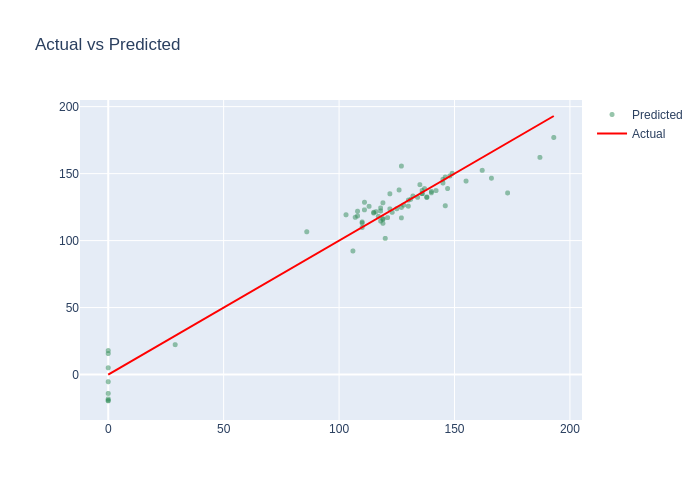

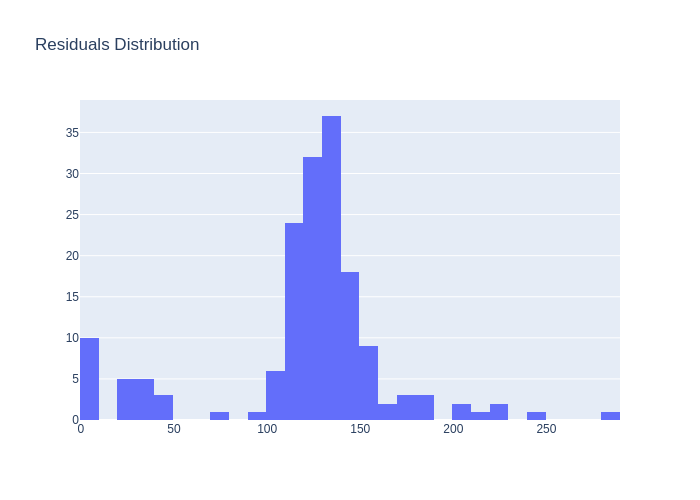

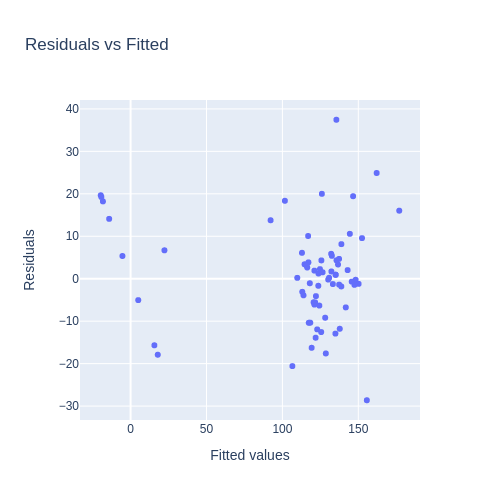

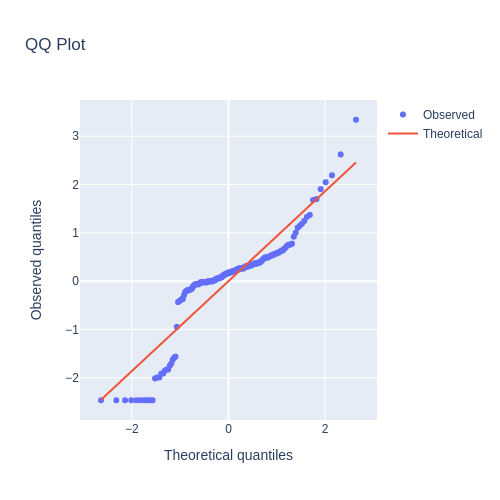

Saved static figure to output/figures/R_gression_lin_aire_simple_20240126_111525.png


In [3]:
# model configuration ant training
from sklearn.linear_model import ElasticNet

lr = ElasticNet(alpha=0, l1_ratio=0)

lr.fit(X_train, y_train)
pred_train_lr = lr.predict(X_train)
pred_test_lr = lr.predict(X_test)


co2.styles.display_combined_report(y_train, pred_train_lr, y_test, pred_test_lr, title='PERFORMANCES DU MODELE DE REGRESSION LINEAIRE')
co2.styles.displayer(pd.DataFrame({'Co2 Observé': y_test, 'Co2 prédit': pred_test_lr},
             index=X_test.index), n=10, title='REGRESSION LINEAIRE: COMPARAISON DE QUELQUES VALEURS')



co2.viz.plot_regression_diagnostics(y_test, pred_test_lr, y_train, "Régression linéaire simple", interactive=True, save=True, format='png', sample=0.05)

# **2. Modèle ElasticNet**

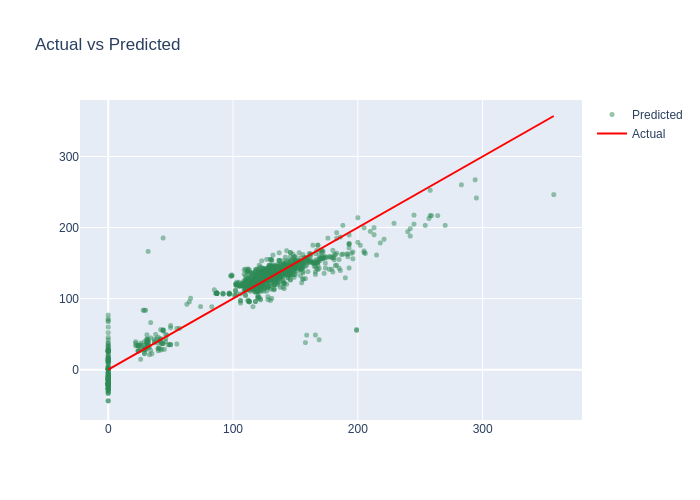

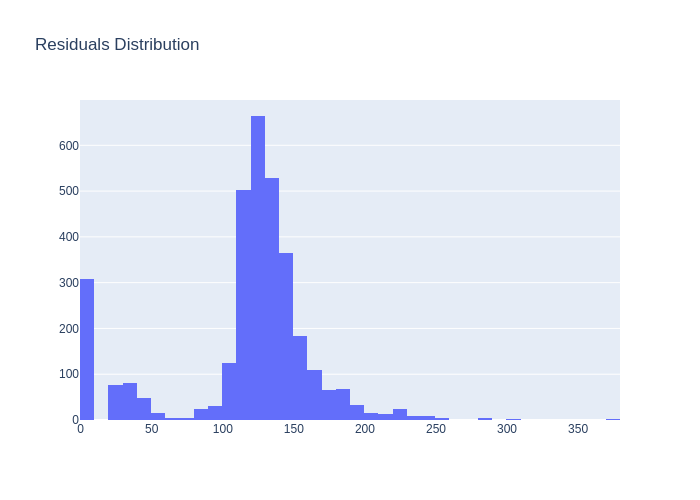

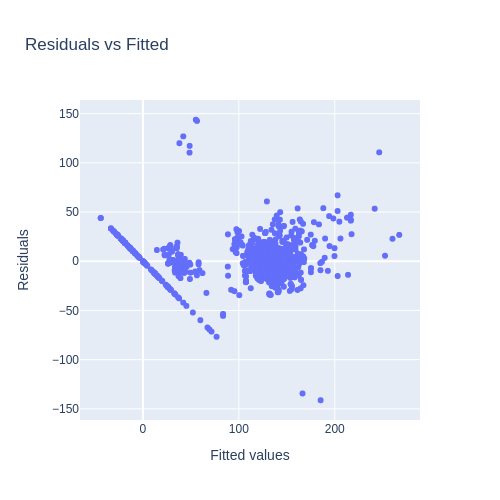

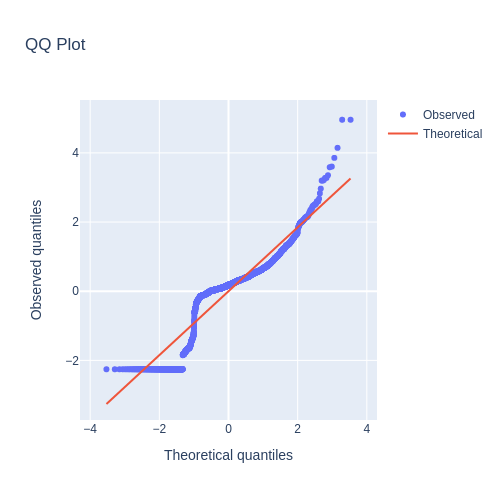

Saved static figure to output/figures/ElasticNet_20240126_111626.png


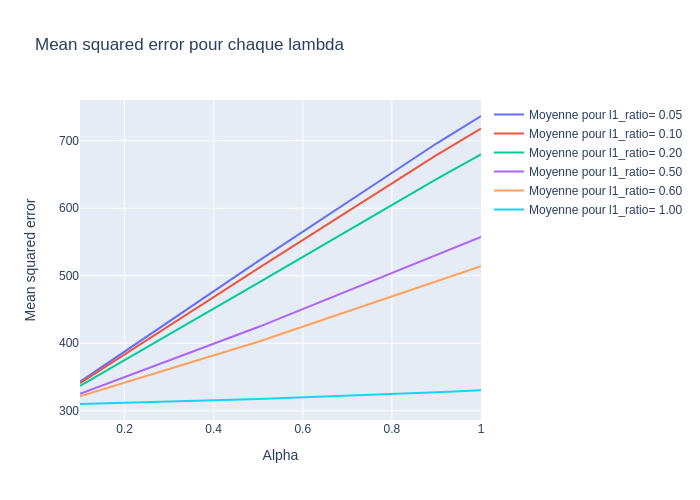

Saved static figure to output/figures/Mean_squared_error_pour_chaque_lambda_20240126_111627.png


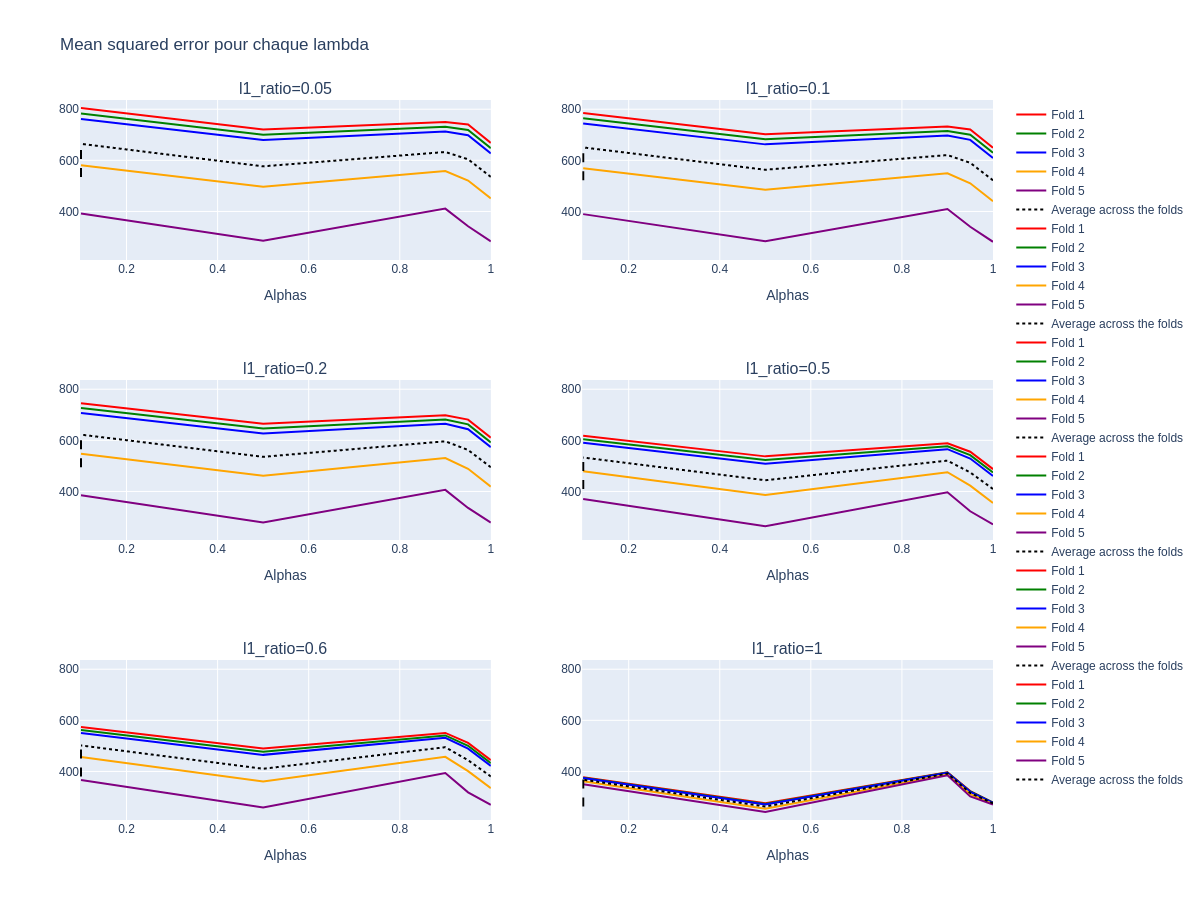

Saved static figure to output/figures/Mean_squared_error_pour_chaque_lambda_20240126_111627.png
CPU times: user 451 ms, sys: 1.23 s, total: 1.68 s
Wall time: 1.15 s


In [6]:
%%time
l1_ratios = [0.05, 0.1, 0.2, 0.5, 0.6, 1]
lr_en = ElasticNetCV(cv=5, l1_ratio=l1_ratios, alphas=[0.1, 0.5, 0.9, 0.95, 1.0], n_jobs=-1)
lr_en.fit(X_train, y_train)
pred_test_en = lr_en.predict(X_test)


#co2.styles.display_combined_report(y_train, lr_en.predict(X_train), y_test, lr_en.predict(X_test), title='PERFORMANCES DU MODELE ELASTIC NET') 

co2.viz.plot_regression_diagnostics(y_test, pred_test_en, y_train, "ElasticNet", interactive=True, save=True, format='png')
co2.viz.plot_lr_elasticnet(lr_en, interactive=False, save=True, format='png')
co2.viz.plot_mse_folds(lr_en, l1_ratios, interactive=False, save=True, format='png')


#co2.data.save_model(lr_en)

# **3. Modèle d'ensemble XGBoost Regressor**

In [4]:
%%time

X_temp, X_test, y_temp, y_test = train_test_split(data, target, test_size = 0.2, random_state = 2)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size = 0.2, random_state = 3)

train = xgb.DMatrix(data = X_train, label = y_train)
test = xgb.DMatrix(data = X_test, label = y_test)
valid = xgb.DMatrix(data = X_valid, label = y_valid)

params = {'booster' : 'gbtree', 'learning_rate' : 0.1, 'objective' : 'reg:linear'}
model = xgb.train(params=params, dtrain = train, num_boost_round = 700, early_stopping_rounds = 15, evals= [(train, 'train'), (test, 'valid')] )
# préferer  'learning_rate' << 1 → 0,01  et num_boost_round grand = 700,

pred_train_xgb = model.predict(train)
pred_test_xgb = model.predict(test)
residuals_test_xgb = y_test - pred_test_xgb


co2.styles.display_combined_report(y_train, pred_train_xgb, y_test, pred_test_xgb, title='PERFORMANCES DU MODELE XGBOOST') 

#co2.data.save_model(model, 'xgb') 

[0]	train-rmse:46.83396	valid-rmse:46.85859
[1]	train-rmse:42.62546	valid-rmse:42.81717
[2]	train-rmse:38.86901	valid-rmse:39.22780
[3]	train-rmse:35.49805	valid-rmse:36.02615
[4]	train-rmse:32.49821	valid-rmse:33.19720
[5]	train-rmse:29.78082	valid-rmse:30.60003
[6]	train-rmse:27.36731	valid-rmse:28.32697
[7]	train-rmse:25.22715	valid-rmse:26.40052
[8]	train-rmse:23.34361	valid-rmse:24.72306
[9]	train-rmse:21.65419	valid-rmse:23.17249
[10]	train-rmse:20.17459	valid-rmse:21.82890
[11]	train-rmse:18.88199	valid-rmse:20.73643
[12]	train-rmse:17.77025	valid-rmse:19.80536
[13]	train-rmse:16.77267	valid-rmse:18.88078
[14]	train-rmse:15.87999	valid-rmse:18.09849
[15]	train-rmse:15.16041	valid-rmse:17.47749
[16]	train-rmse:14.47811	valid-rmse:16.87996
[17]	train-rmse:13.89796	valid-rmse:16.37443
[18]	train-rmse:13.38364	valid-rmse:15.94421


[21:58:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076482591/work/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.


[19]	train-rmse:12.92228	valid-rmse:15.52592
[20]	train-rmse:12.58009	valid-rmse:15.26867
[21]	train-rmse:12.20911	valid-rmse:15.00959
[22]	train-rmse:11.94024	valid-rmse:14.81699
[23]	train-rmse:11.66793	valid-rmse:14.60502
[24]	train-rmse:11.42348	valid-rmse:14.44662
[25]	train-rmse:11.23843	valid-rmse:14.34150
[26]	train-rmse:11.09516	valid-rmse:14.25308
[27]	train-rmse:10.91718	valid-rmse:14.12942
[28]	train-rmse:10.79452	valid-rmse:14.05589
[29]	train-rmse:10.64820	valid-rmse:13.98241
[30]	train-rmse:10.52354	valid-rmse:13.90175
[31]	train-rmse:10.37059	valid-rmse:13.84508
[32]	train-rmse:10.21752	valid-rmse:13.80019
[33]	train-rmse:9.94393	valid-rmse:13.61884
[34]	train-rmse:9.80989	valid-rmse:13.58475
[35]	train-rmse:9.60839	valid-rmse:13.47757
[36]	train-rmse:9.45611	valid-rmse:13.41984
[37]	train-rmse:9.29366	valid-rmse:13.34581
[38]	train-rmse:9.17412	valid-rmse:13.29982
[39]	train-rmse:9.03393	valid-rmse:13.19563
[40]	train-rmse:8.95880	valid-rmse:13.13856
[41]	train-rmse:8.

,Train Set,Test Set
Mean Squared Error,27.218,136.127
Root Mean Squared Error,5.217,11.667
Mean Absolute Error,2.851,4.694
R2 Score,0.990,0.948


<class 'pandas.io.formats.style.Styler'>
CPU times: user 36.1 s, sys: 111 ms, total: 36.2 s
Wall time: 2.7 s


In [6]:
co2.viz.plot_regression_diagnostics(y_test, pred_test_xgb, residuals_test_xgb, "PERFORMANCES DU MODELE XGBOOST REGRESSOR", 
                                    interactive=False, save=True, format='png', sample=0.05)

# **4. Interprétabilité du modèle XGB Linear Regressor**

[1/24] features -------------------- Time elapsed: 0 seconds

[24/24] features ████████████████████ Time elapsed: 0 seconds

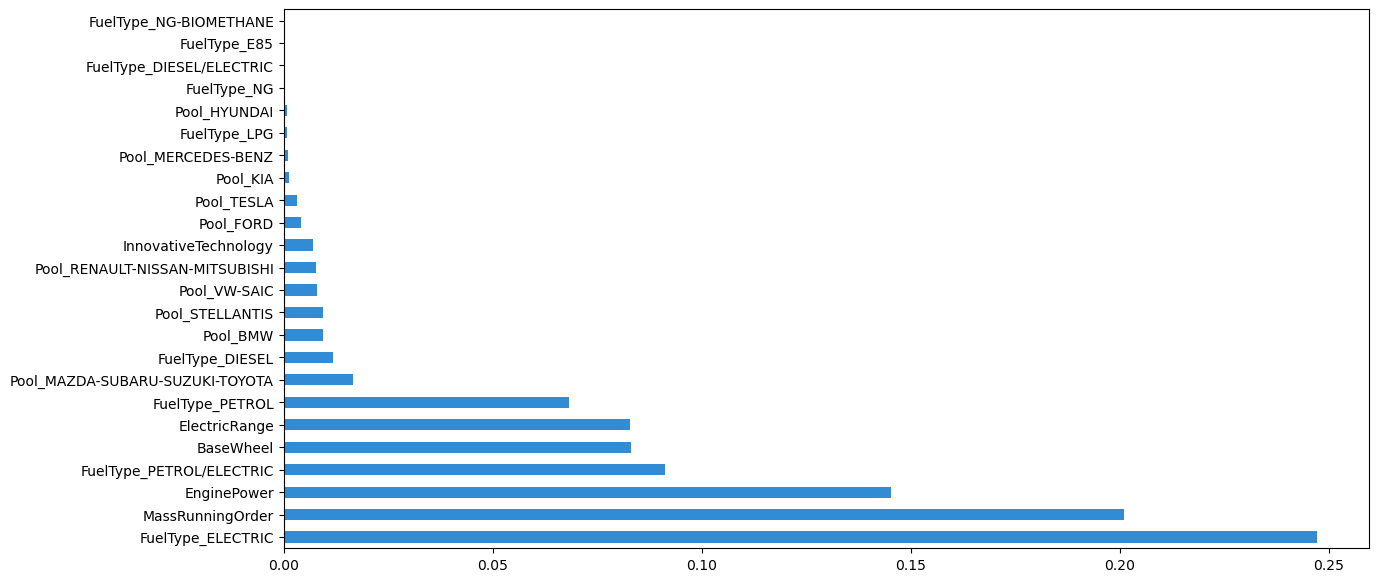

In [4]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
from skater.model import InMemoryModel

# Define a prediction function for the model
def predict_xg(x):
    return pd.DataFrame(model.predict(xgb.DMatrix(x)))

# Create an in-memory model
model_1 = InMemoryModel(predict_xg, examples = X_train)

# Create an interpreter
interpreter = Interpretation(X_train, feature_names=X_train.columns)

# Set the figure size for the plot
plt.rcParams['figure.figsize'] = (14,7)

# Generate a feature importance plot
plots = interpreter.feature_importance.plot_feature_importance(model_1, ascending=True)

/home/mln/miniconda3/envs/co2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[11:17:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076482591/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



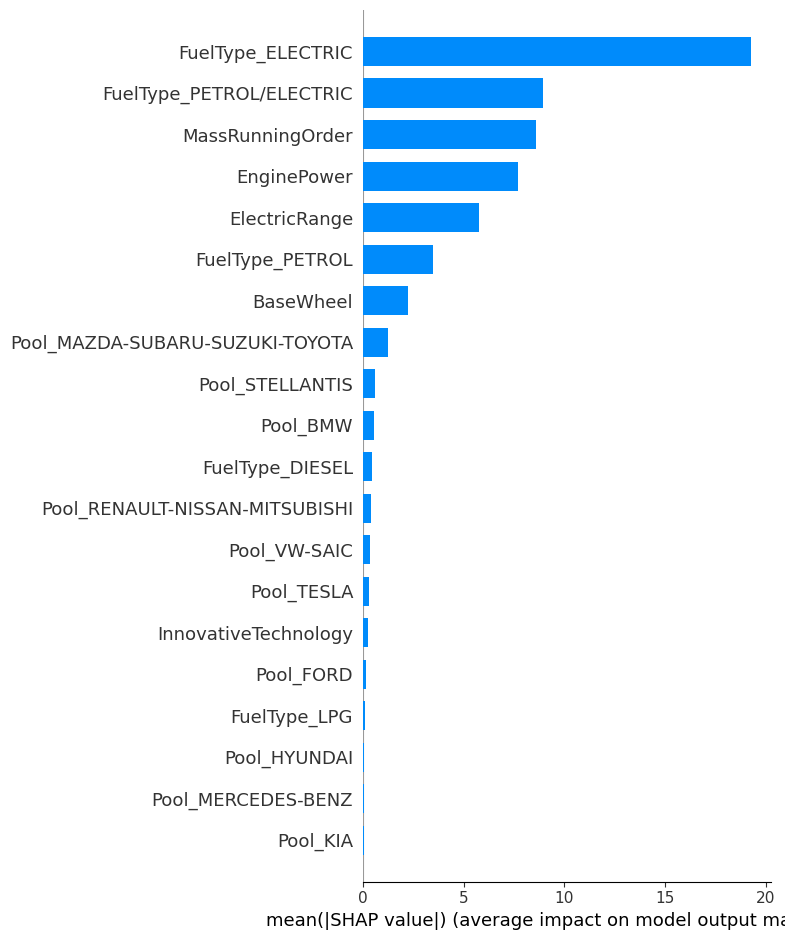

SHAP values saved at ../output/interpretability/ndarray_shap_values_20240116_111713.csv
Explainer information saved at ../output/interpretability/ndarray_explainer_20240116_111713.csv


In [7]:

# Create a SHAP explainer and calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Create a SHAP explanation object
shap_explanation = shap.Explanation(values=shap_values, data=X_train, feature_names=X_train.columns)

# Generate SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Generate SHAP dependence plots
co2.viz.plot_shap_dependence("ElectricRange", "MassRunningOrder", shap_values, X_test, sample=0.05, save=True, format='png')
co2.viz.plot_shap_dependence("ElectricRange", "FuelType_ELECTRIC", shap_values, X_test, sample=0.05, save=True, format='png')
co2.viz.plot_shap_dependence("BaseWheel", "EnginePower", shap_values, X_test, sample=0.05, save=True, format='png')

co2.viz.plot_shap_dependence("MassRunningOrder", "EnginePower", shap_values, X_test, sample=0.05, save=True, format='png')

# Visualize the first tree from the model
xgb.to_graphviz(model, num_trees=0)

co2.data.save_shap_values(shap_values, X_test)

In [ ]:
# Récupération des prédictions

# pred_test = model.predict(test)
# pred_train = model.predict(train)

#Entraînement du modèle
sg_clf = LinearRegression()
sg_clf.fit(X_train, pred_train)

# Scores du modèle
sg_clf.score(X_test, y_test)
# print(classification_report(y_test, sg_clf.predict(X_test)))

# #Comparaison des prédictions
# print(sum(preds!=sg_clf.predict(X_train)))

# # Comparaison des prédictions sur le jeu de test
# probs = bst.predict(dtest)
# preds = [0 if x<0.5 else 1 for x in probs]

0.8769934526561693